In [5]:
pip install ucimlrepo

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [7]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# metadata
print(cdc_diabetes_health_indicators.metadata)

# variable information
print(cdc_diabetes_health_indicators.variables)


{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

In [9]:
# Impute missing values using median instead of mean for a change
medians = X.median()
X_filled = X.fillna(medians)

# Convert categorical variables using one-hot encoding
X_encoded = pd.get_dummies(X_filled)

# Standardize the features using RobustScaler which is less sensitive to outliers
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Split the dataset into training, validation, and test sets with a different test size
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.int64))
X_val_tensor = torch.tensor(X_val.astype(np.float32))
y_val_tensor = torch.tensor(y_val.values.astype(np.int64))
X_test_tensor = torch.tensor(X_test.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.int64))

# Create DataLoaders for training and validation sets using a different batch size
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Display the setup
print(f'Training set size: {len(train_loader.dataset)}')
print(f'Validation set size: {len(val_loader.dataset)}')
print(f'Test set size: {len(y_test_tensor)}')


Training set size: 159818
Validation set size: 17758
Test set size: 76104


In [19]:
# Convert the targets to float when creating TensorDatasets
y_train_tensor = torch.tensor(y_train.values.astype(np.float32))
y_val_tensor = torch.tensor(y_val.values.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32))

# The rest of your DataLoader setup code remains the same

# Define the Neural Network Model
class DiabetesModel(nn.Module):
    def __init__(self):
        super(DiabetesModel, self).__init__()
        self.layer1 = nn.Linear(X_train_tensor.shape[1], 64)
        self.layer2 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(0.1)
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.output_layer(x))
        return x

# Instantiate the model
model = DiabetesModel()
model.to(device)

# Setup the Loss Function and Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Implement a learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training Loop with monitoring both training and validation losses
num_epochs = 30
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait before stopping if no improvement
patience_counter = 0

train_losses = []  # List to store training losses
val_losses = []    # List to store validation losses

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device).float().view(-1, 1)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculate average training loss for the epoch
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, targets in val_loader:
            data = data.to(device)
            targets = targets.to(device).float().view(-1, 1)
            outputs = model(data)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    # Calculate average validation loss for the epoch
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # Check if we need to apply early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved Best Model")
        patience_counter = 0  # reset counter if improvement
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Validation loss did not improve for {} epochs, stopping training.".format(patience))
    #         break

Epoch 1, Training Loss: 0.3234, Validation Loss: 0.3171
Saved Best Model
Epoch 2, Training Loss: 0.3154, Validation Loss: 0.3175
Epoch 3, Training Loss: 0.3143, Validation Loss: 0.3158
Saved Best Model
Epoch 4, Training Loss: 0.3140, Validation Loss: 0.3160
Epoch 5, Training Loss: 0.3134, Validation Loss: 0.3147
Saved Best Model
Epoch 6, Training Loss: 0.3129, Validation Loss: 0.3148
Epoch 7, Training Loss: 0.3124, Validation Loss: 0.3152
Epoch 8, Training Loss: 0.3121, Validation Loss: 0.3160
Epoch 9, Training Loss: 0.3121, Validation Loss: 0.3147
Epoch 10, Training Loss: 0.3116, Validation Loss: 0.3169
Validation loss did not improve for 5 epochs, stopping training.
Epoch 11, Training Loss: 0.3117, Validation Loss: 0.3156
Validation loss did not improve for 5 epochs, stopping training.
Epoch 12, Training Loss: 0.3111, Validation Loss: 0.3144
Saved Best Model
Epoch 13, Training Loss: 0.3109, Validation Loss: 0.3151
Epoch 14, Training Loss: 0.3109, Validation Loss: 0.3142
Saved Best Mo

In [38]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate the model on the test set
model.eval()
test_loss = 0
y_pred = []
y_true = []

with torch.no_grad():
    for data, targets in DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32):
        data = data.to(device)
        targets = targets.to(device).float().view(-1, 1)
        outputs = model(data)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        predicted_labels = (outputs > 0.5).float()
        y_pred.extend(predicted_labels.cpu().numpy())
        y_true.extend(targets.cpu().numpy())

test_loss /= (len(X_test_tensor) / 32)
print(f'Test Loss: {test_loss:.4f}')

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, np.round(y_pred))
print(f'Test Accuracy: {accuracy:.4f}')


Test Loss: 0.3119
Test Accuracy: 0.8671


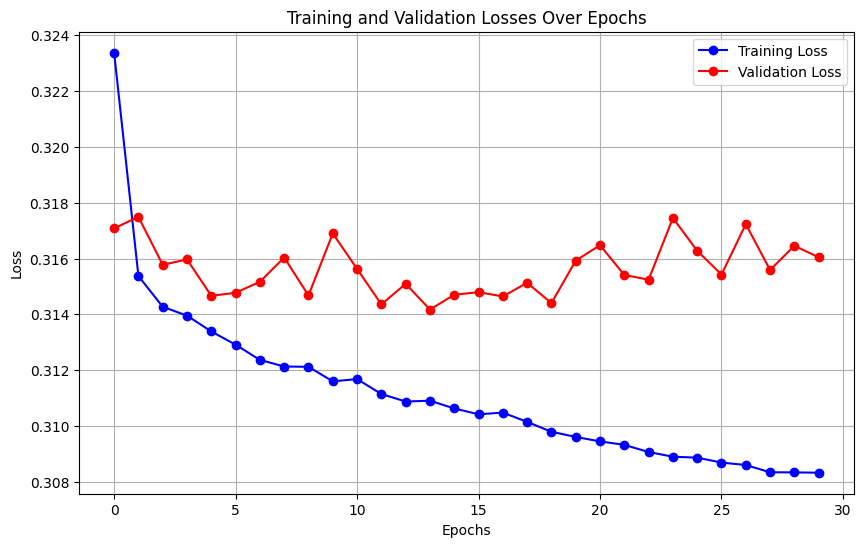

In [39]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.plot(train_losses, 'b-o', label='Training Loss')
plt.plot(val_losses, 'r-o', label='Validation Loss')

# Adding titles and labels
plt.title('Training and Validation Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Adding grid
plt.grid(True)

# Annotate some points
def annotate_points(x, y, ax):
    for i, (txt1, txt2) in enumerate(zip(x, y)):
        ax.annotate(f'{txt2:.2f}', (txt1, txt2), textcoords="offset points", xytext=(0,10), ha='center')


# Show legend
plt.legend()

# Show plot
plt.show()


In [36]:
# Evaluate the model on the test set and record test loss at every batch
model.eval()
test_losses = []
y_pred = []
y_true = []

with torch.no_grad():
    for data, targets in DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32):
        data = data.to(device)
        targets = targets.to(device).float().view(-1, 1)
        outputs = model(data)
        loss = criterion(outputs, targets)
        test_losses.append(loss.item())
        predicted_labels = (outputs > 0.5).float()
        y_pred.extend(predicted_labels.cpu().numpy())
        y_true.extend(targets.cpu().numpy())

average_test_loss = sum(test_losses) / len(test_losses)
print(f'Average Test Loss: {average_test_loss:.4f}')


Average Test Loss: 0.3118


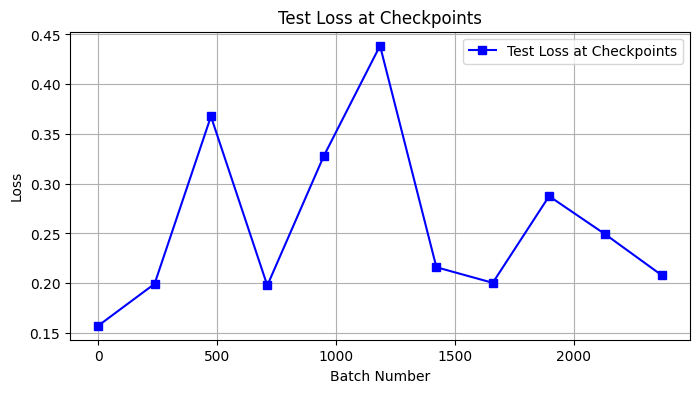

In [37]:
import matplotlib.pyplot as plt

# Determine checkpoints - record a loss every 10% of the dataset or at least one
checkpoints = range(0, len(test_losses), max(1, len(test_losses) // 10))
selected_test_losses = [test_losses[i] for i in checkpoints]

# Plotting the test losses at checkpoints
plt.figure(figsize=(8, 4))
plt.plot(checkpoints, selected_test_losses, 'bs-', label='Test Loss at Checkpoints')
plt.title('Test Loss at Checkpoints')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig('pytorch_diabetes_test_loss.svg', format='svg')
plt.show()


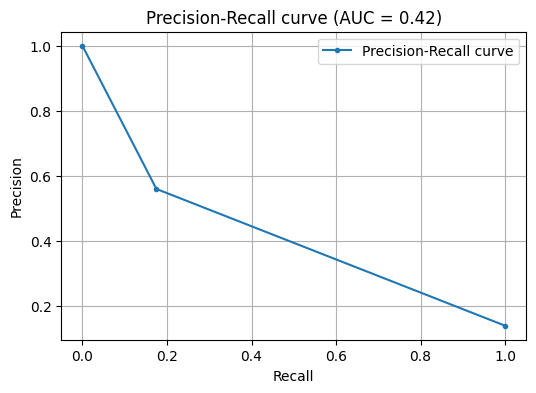

In [42]:
from sklearn.metrics import precision_recall_curve, auc

# Calculate precision and recall values
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# Calculate area under the precision-recall curve
auc_precision_recall = auc(recall, precision)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AUC = {auc_precision_recall:.2f})')
plt.legend()
plt.grid(True)
plt.show()
